In [1]:
!python --version

Python 3.8.8


#### Importing necessary modules 

In [1]:
# Import necessary libraries
import os
import pandas as pd 
import numpy as np 
import tqdm
from pathlib import Path
import cv2 as cv
import PIL
from PIL import Image,UnidentifiedImageError
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from alive_progress import alive_bar

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Activation
from keras.models import save_model,load_model

print(tf.__version__)

2.4.1


- Setting up the image size and max image pixels

In [7]:
Image.MAX_IMAGE_PIXELS = 933120000
IMG_SIZE = (120,120)

- Setting up the Directories

In [8]:
# DATASET PATHS
DATASET_DIR = Path('NEW_DATASET_10')

In [9]:
# Setting Up Directories

# TRAIN DATA PATH
TRAIN_CSV_PATH = os.path.join(DATASET_DIR,'TRAIN','multimodal_train.csv')
TRAIN_IMG_PATH = os.path.join(DATASET_DIR,'TRAIN','IMAGES')

# TEST DATA PATH
TEST_CSV_PATH = os.path.join(DATASET_DIR,'TEST','multimodal_test.csv')
TEST_IMG_PATH = os.path.join(DATASET_DIR,'TEST','IMAGES')

# VALIDATE DATA PATH
VALIDATE_CSV_PATH = os.path.join(DATASET_DIR,'VALIDATE','multimodal_validate.csv')
VALIDATE_IMG_PATH = os.path.join(DATASET_DIR,'VALIDATE','IMAGES')

# PRE_PROCESSED DATA PATHS
PRE_PROCESSED_TRAIN_DATA_PATH = os.path.join(DATASET_DIR,'PROCESSED_DATA','train_data.npz')
PRE_PROCESSED_TEST_DATA_PATH = os.path.join(DATASET_DIR,'PROCESSED_DATA','test_data.npz')
PRE_PROCESSED_VALIDATE_DATA_PATH = os.path.join(DATASET_DIR,'PROCESSED_DATA','validate_data.npz')

# Model Outputs
MODEL_OUTPUT_DIR = Path()

#### Image Preprocessing

- Loading the Training Data 

In [10]:
train_csv_df = pd.read_csv(TRAIN_CSV_PATH,low_memory=False)
train_csv_df.head()

,Unnamed: 0,Unnamed: 0.1,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,436310,436310,jessicaO_o,this perfectlysized woody doll stuck to the ba...,1.569282e+09,i.redd.it,True,d8evxg,https://preview.redd.it/mss81mprifo31.jpg?widt...,NaN,4.0,37,mildlyinteresting,This perfectly-sized Woody doll stuck to the b...,0.78,1,0,0
1,112761,112761,NaN,large man jumping into a pool,1.406789e+09,dumpaday.com,True,2c7vxd,https://external-preview.redd.it/g7DkrdPEupDdZ...,NaN,24.0,64,photoshopbattles,Large man jumping into a pool,0.72,1,0,0
2,335972,335972,Duckitor,cops man sets up fake dui checkpoint gets char...,1.460131e+09,wtae.com,True,4dwzqp,https://external-preview.redd.it/twPZ8mH_gGc--...,NaN,0.0,36,nottheonion,"Cops: Man sets up fake DUI checkpoint, gets ch...",0.81,1,0,0
3,185095,185095,SuperKozz,turtle enjoying the sun,1.512896e+09,i.redd.it,True,7iszja,https://preview.redd.it/2na6m5s382301.jpg?widt...,NaN,5.0,11,photoshopbattles,PsBattle: Turtle enjoying the sun,0.84,1,0,0
4,189772,189772,nicksatdown,grandfather who beat three types of cancer com...,1.421564e+09,telegraph.co.uk,True,2st8j2,https://external-preview.redd.it/FBf2kiPgNr8K5...,NaN,1.0,23,upliftingnews,Grandfather who beat three types of cancer com...,0.85,1,0,0


- Check for skewness

In [11]:
grouped_df = train_csv_df.groupby(['2_way_label'])
true_df = grouped_df.get_group(1)
false_df = grouped_df.get_group(0)

In [12]:
print(true_df.shape)
print(false_df.shape)

(28200, 18)
(28200, 18)


- Extracting only necessary fields from dataset

In [13]:
train_df = shuffle(train_csv_df[['id','2_way_label']])
print(train_df.shape)
train_df.head()

(56400, 2)


,id,2_way_label
44771,90f69w,0
3754,86spl5,1
4960,13nri7,1
50598,dc8zn4a,0
41337,cjjosiu,0


- Function to check wether the loaded image is corrupted or not?

In [14]:
def isImgCorrupted(img):
    try:
        im = Image.open(img)
        im.verify()
        return False

    except FileNotFoundError:
        return True
    
    except SyntaxError:
        return True
    
    except PIL.UnidentifiedImageError:
        return True

In [15]:
# TESTING PURPOSES
for i, row in train_df.head().iterrows():
    print('Index: {}'.format(i))
    img, label = row.tolist()
    print(f'IMG = {img}, Label = {label}')

# img,label = train_csv_df.loc[0,['id','2_way_label']].tolist()
# # train_df.shape
# img, label

Index: 44771
IMG = 90f69w, Label = 0
Index: 3754
IMG = 86spl5, Label = 1
Index: 4960
IMG = 13nri7, Label = 1
Index: 50598
IMG = dc8zn4a, Label = 0
Index: 41337
IMG = cjjosiu, Label = 0


- Function to preprocess the dataframe to required fields
    - Checks for Image Corruption
    - Converts the Image data to numpy array
    - Returns
        - X -> contains all the image data 
        - Y -> contains the labels of images
        - id -> id's of the respective images

In [16]:
def preprocessImageData(df,IMG_PATH):
    X = []
    y = []
    id = []
 
    with alive_bar(df.shape[0],title='Processing Image Data') as pbar:
        for i, row in df.iterrows():
            img, label = row.tolist()
            impath = os.path.join(IMG_PATH, f'{img}.jpg')
            try:
                if not isImgCorrupted(impath):
                    imarray = cv.imread(impath, cv.IMREAD_GRAYSCALE)
                    if imarray is not None:
                        new_imarray = cv.resize(imarray, IMG_SIZE)
                        X.append(new_imarray)
                        y.append(label)
                        id.append(img)
    
            except Exception as e:
                print(f"{img}: {e}")
            pbar()
    # for i, row in df.iterrows():
    #     img, label = row.tolist()
    #     impath = os.path.join(IMG_PATH, f'{img}.jpg')
    #     try:
    #         if not isImgCorrupted(impath):
    #             imarray = cv.imread(impath, cv.IMREAD_GRAYSCALE)
    #             if imarray is not None:
    #                 new_imarray = cv.resize(imarray, IMG_SIZE)
    #                 X.append(new_imarray)
    #                 y.append(label)
    #                 id.append(img)
 
    #     except Exception as e:
    #         print(f"{img}: {e}")
 
    # Converting X, y,id to numpy array
    X = np.array(X).reshape(-1,120,120,1)
    y = np.array(y)
    id = np.array(id)
 
    # Normalize X
    X = X / 255.0
 
    return (X,y,id)

- Preprocessing the Training dataset

In [17]:
X_train, y_train, _ = preprocessImageData(train_df,TRAIN_IMG_PATH)
X_train.shape

(56357, 120, 120, 1)

In [14]:
# # Save the training data
# np.save(r'Image_Processing\X_train.npy',X_train)
# np.save(r'Image_Processing\y_train.npy',y_train)

In [15]:
# Loading the training data. Use only in need

# data = np.load(PRE_PROCESSED_TRAIN_DATA_PATH)
# X_train = data['x']
# y_train = data['y']
# print(X_train.shape)
# print(y_train.shape)

In [18]:
input_shape = X_train.shape[1:]

### Defining & Training the model

#### Defining the model with l2 regularizer

In [2]:
# Defining the model

model = Sequential()
# Adding a densely-connected layer with 64 units to the model
model.add(Conv2D(64, (3,3), activation='relu',input_shape=(120,120,1),kernel_regularizer='l2'))
model.add(MaxPooling2D(pool_size = (2,2)))
# Add another
model.add(Conv2D(64, (3,3), activation='relu',kernel_regularizer='l2'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

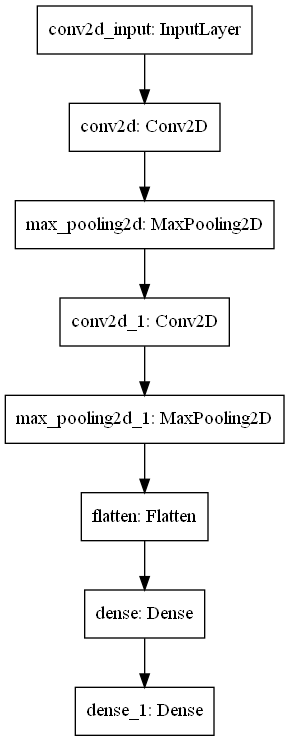

In [9]:
from keras.utils import plot_model

plot_model(model,show_layer_names=True,show_shapes=False)

In [18]:
# model = Sequential()

# # Adding a densely-connected layer with 64 units to the model
# model.add(Conv2D(64, (3,3), activation='relu',input_shape=input_shape,kernel_regularizer='l2'))
# model.add(MaxPooling2D(pool_size = (2,2)))
# # Add another
# model.add(Conv2D(64, (3,3), activation='relu',kernel_regularizer='l2'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# # Add another
# model.add(Conv2D(64, (3,3), activation='relu',kernel_regularizer='l2'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# # Add another
# model.add(Conv2D(64, (3,3), activation='relu',kernel_regularizer='l2'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Flatten())

# for i in range(4):
#     model.add(Dense(64,activation='relu'))

# model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer='adam',
#                     loss='binary_crossentropy',
#                     metrics=['accuracy'])

In [19]:
model.summary()

- Model Training

In [20]:
model_history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

ValueError: Training data contains 0 samples, which is not sufficient to split it into a validation and training set as specified by `validation_split=0.2`. Either provide more data, or a different value for the `validation_split` argument.

- Displaying the accuracy & loss

In [ ]:
# for model
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# plt.savefig('Image_Processing_Outputs\model_accuracy.pdf')

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
# plt.savefig('Image_Processing_Outputs\model_loss.pdf')

- Saving the model 

In [ ]:
model.save(r'Image_Processing\model.h5')

- Load back model

In [ ]:
# model = load_model(r'Image_Processing\model.h5')
# model.summary()

- Predicting Test set

In [ ]:
# Test
test_csv_df = pd.read_csv(TEST_CSV_PATH)
test_csv_df.head()

In [ ]:
test_df = test_csv_df[['id','2_way_label']]
test_df.head()

In [ ]:
X_test, y_test, id = preprocessImageData(test_df, TEST_IMG_FOLDER_PATH)
X_test.shape

In [ ]:
# # Save the Text data
# np.save(r'Image_Processing\X_test.npy',X_test)
# np.save(r'Image_Processing\y_test.npy',y_test)
# np.save(r'Image_Processing\id.npy',id)

In [ ]:
# Load the Text Data

# data = np.load(PRE_PROCESSED_TEST_DATA_PATH)
# X_test,y_test,id = data['x'],data['y'],data['id']
# print(X_test.shape[1:])
# print(y_test.shape[1:])

In [ ]:
predictions = model.predict(X_test)

In [ ]:
# Rounding the results
predicted_val = [int(round(p[0])) for p in predictions]

In [ ]:
results_dict = {
    'Image ID' : id,
    'Correct O/P' : y_test,
    'Predicted O/P' : predicted_val
}

In [ ]:
result_df = pd.DataFrame(results_dict)
result_df.to_csv('Image_Processing_Simple_CNN_Results.csv', index=False)

In [ ]:
result_df.head()